In [24]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=15,6

# Load Data

In [26]:
data=pd.read_csv('AirPassengers.csv')
data.head()
data.dtypes

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


Month          object
#Passengers     int64
dtype: object

In [27]:
# Convert time format from object to datetime
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month',date_parser=dateparse)
data.head()
data.index

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [28]:
ts = data['#Passengers'] 
ts.head(10)

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
Name: #Passengers, dtype: int64

# Check Stationarity

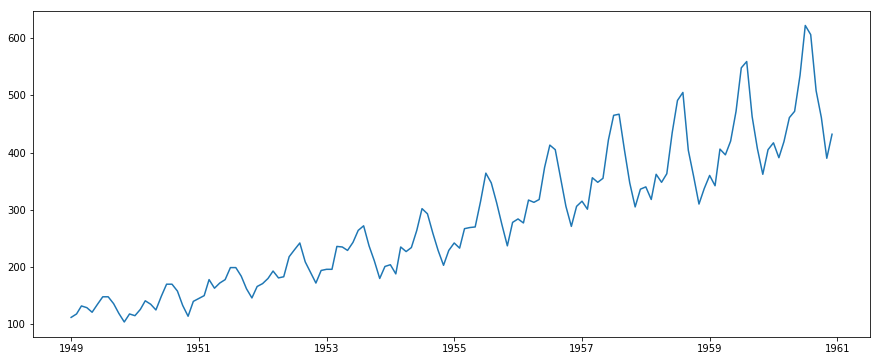

In [30]:
#stationarity is the basis of TS model, in which its statistical properties such as mean, variance remain constant over time
plt.plot(ts);

In [50]:
# From graph we can find it visually shows strong seasonal variations, But no strong proof it's stationarity or not, so we need statistically prove that

### Option one: Perform Rolling Statistics

In [ ]:
# Since we still see the improving trend, so we plot the moving average or moving variance and see if it varies with time 

In [43]:
def test_stationarity1(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.Series.rolling(timeseries, window=12,center=False).mean()
    rolstd = pd.Series.rolling(timeseries, window=12,center=False).std()
    
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean over time')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std over time')
    print ('Graphs of Rolling Statistics Test:')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

Graphs of Rolling Statistics Test:


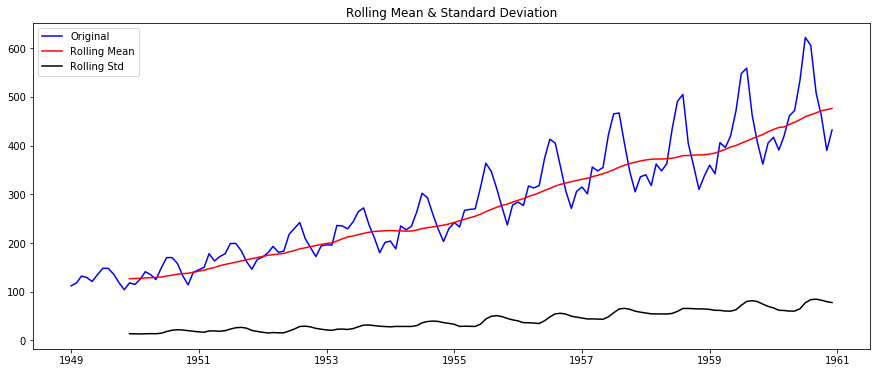

In [44]:
test_stationarity1(ts)

### Option two: Perform Dickey-Fuller Test

In [ ]:
# According to the test result, if 'Test Statistic' is less than the ‘Critical Value’, we can say that the series is stationary. 

In [48]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity2(timeseries):
     #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    test = adfuller(timeseries, autolag='AIC')
    output = pd.Series(test[0:2], index=['Test Statistic','p-value'])
    for key,value in test[4].items():
        output['Critical Value (%s)'%key] = value
    print (output)


In [49]:
test_stationarity2(ts)

Results of Dickey-Fuller Test:
Test Statistic          0.815369
p-value                 0.991880
Critical Value (1%)    -3.481682
Critical Value (5%)    -2.884042
Critical Value (10%)   -2.578770
dtype: float64


In [ ]:
# From result above, we can find that it is actually not stationary

# Transform to a Time Series Stationary

In [ ]:
'''
Reasons that makes it unstationary:
1. Trend – varying mean over time. 
2. Seasonality – variations at specific time-frames. 
Solution here is to estimate the trend and seasonality in the series and remove those from the series to get a stationary series
'''

### Use transformation to eliminate trend

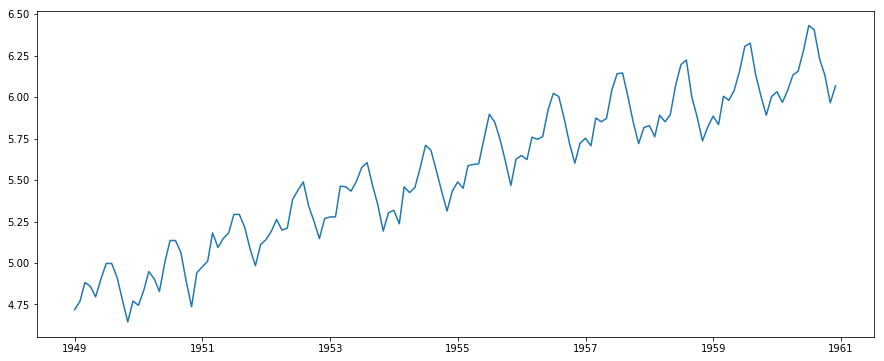

In [56]:
# apply transformation which penalize higher values more than smaller values since this data has obvious improving trend
ts_log = np.log(ts)
plt.plot(ts_log);

### Reduce trend & seasonality

In [57]:
# From above we can find it's still not obvious, we can try to estimate or model this trend and then remove it from the series
# To remove trend, we have to ways: difference and decomposition

#### Option one: Difference

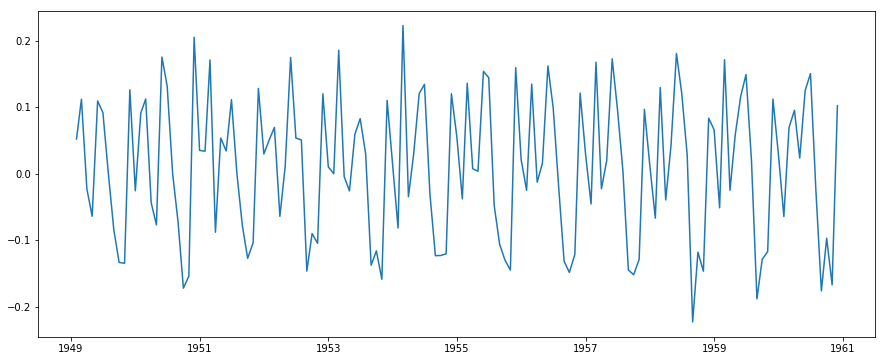

In [59]:
ts_log_diff = ts_log - ts_log.shift() #Take first order differencing
plt.plot(ts_log_diff);

Graphs of Rolling Statistics Test:


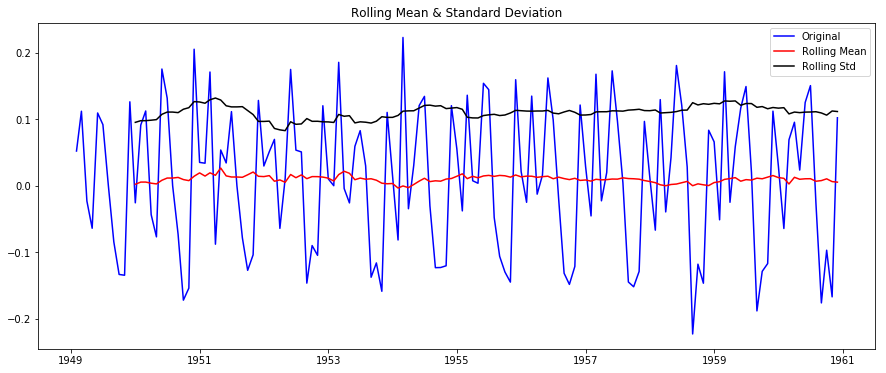

Results of Dickey-Fuller Test:
Test Statistic         -2.717131
p-value                 0.071121
Critical Value (1%)    -3.482501
Critical Value (5%)    -2.884398
Critical Value (10%)   -2.578960
dtype: float64


In [60]:
# It seems it's better, still let's double check with our test funciton
ts_log_diff.dropna(inplace=True)
test_stationarity1(ts_log_diff)
test_stationarity2(ts_log_diff)

In [ ]:
# From result above, we can find that it's less than the 10% critical value, thus the TS is stationary with 90% confidence.

#### Option two: Decomposing

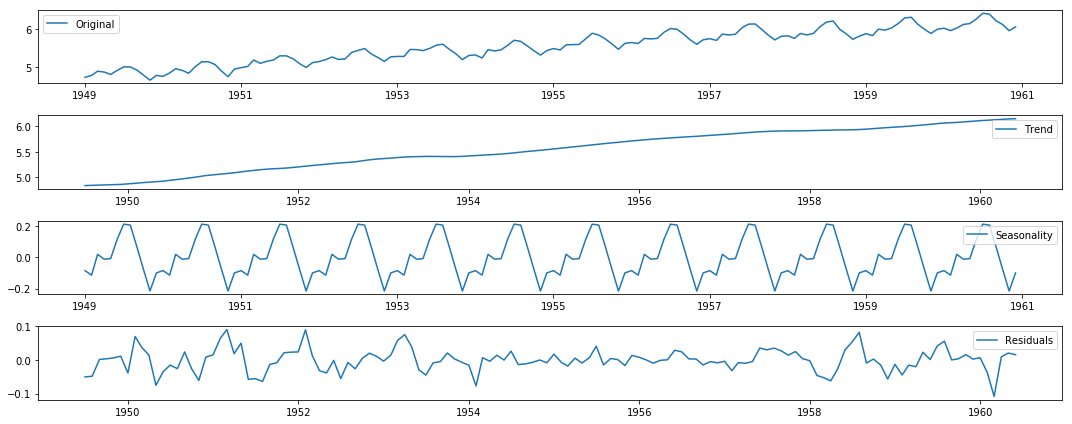

In [63]:
# Seperately model trend, seasonality and the remaining part 
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(4,1,1);
plt.plot(ts_log, label='Original');
plt.legend(loc='best');
plt.subplot(4,1,2);
plt.plot(trend, label='Trend');
plt.legend(loc='best');
plt.subplot(4,1,3);
plt.plot(seasonal,label='Seasonality');
plt.legend(loc='best');
plt.subplot(4,1,4);
plt.plot(residual, label='Residuals');
plt.legend(loc='best');
plt.tight_layout();

Graphs of Rolling Statistics Test:


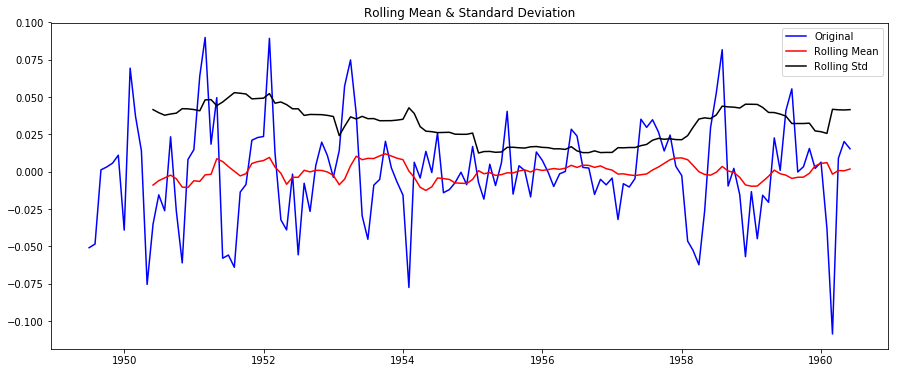

Results of Dickey-Fuller Test:
Test Statistic         -6.332387e+00
p-value                 2.885059e-08
Critical Value (1%)    -3.485122e+00
Critical Value (5%)    -2.885538e+00
Critical Value (10%)   -2.579569e+00
dtype: float64


In [64]:
# Check the stationary of the residual and model it
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity1(ts_log_decompose);
test_stationarity2(ts_log_decompose);

In [65]:
# From result above we can find it's significantly lower than the 1% critical value, which has 99% of stationary.

# Forecasting a Time Series

In [ ]:
# Apply ARIMA, standing for Auto-Regressive Integrated Moving Averages, which is like a linear equation

'''
Parameters of ARIMA model:
Number of AR (Auto-Regressive) terms (p): AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
Number of MA (Moving Average) terms (q): MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.
Number of Differences (d): These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.
'''

In [ ]:
# To decide parameter p and q, we need to use ACF(Autocorrelation Function) plot and PACF(Partial Autocorrelation Function) plot

In [67]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

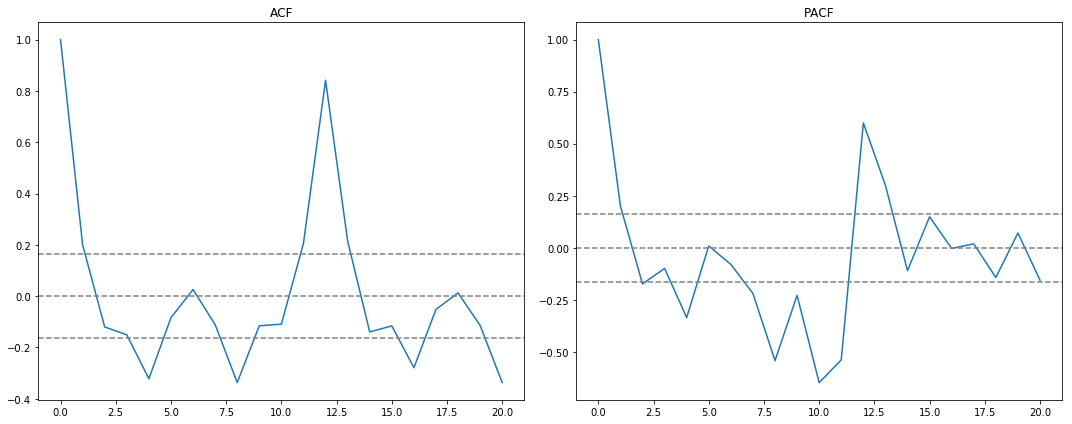

In [72]:
#Plot ACF: 
plt.subplot(121); 
plt.plot(lag_acf);
plt.axhline(y=0,linestyle='--',color='gray');
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray');
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray');
plt.title('ACF');

#Plot PACF:
plt.subplot(122);
plt.plot(lag_pacf);
plt.axhline(y=0,linestyle='--',color='gray');
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray');
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray');
plt.title('PACF');
plt.tight_layout();

In [ ]:
'''
p – The lag value where the PACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case p=2.
q – The lag value where the ACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case q=2.
'''

#### ARIMA Model One: AR Model

E:\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
E:\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
E:\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


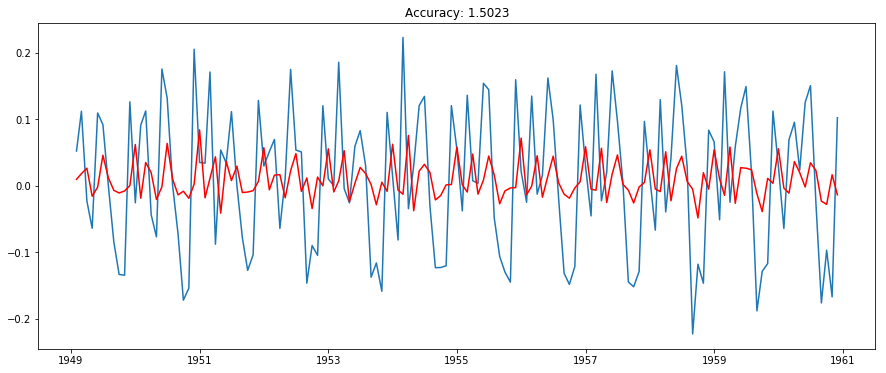

In [136]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(ts_log, order=(2, 1, 0)) # use the order argument to decide p,d,q values of ARIMA model
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff);
plt.plot(results_AR.fittedvalues, color='red');
plt.title('Accuracy: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2));

#### ARIMA Model Two: MA Model

E:\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
E:\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
E:\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


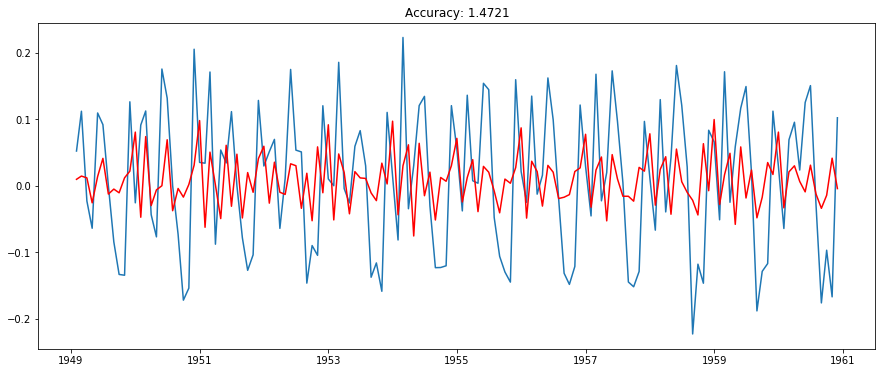

In [112]:
model = ARIMA(ts_log, order=(0, 1, 2)) # use the order argument to decide a tuple (p,d,q) of ARIMA model
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff);
plt.plot(results_MA.fittedvalues, color='red');
plt.title('Accuracy: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2));

#### ARIMA Model Three: Combined Model

E:\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
E:\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
E:\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


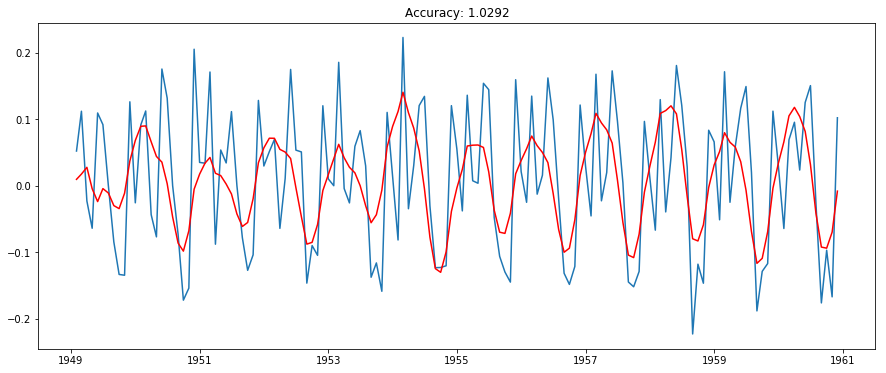

In [114]:
model = ARIMA(ts_log, order=(2, 1, 2))  # use the order argument to decide p,d,q values of ARIMA model
results_comb = model.fit(disp=-1)  
plt.plot(ts_log_diff);
plt.plot(results_comb.fittedvalues, color='red');
plt.title('Accuracy: %.4f'% sum((results_comb.fittedvalues-ts_log_diff)**2));

# Take it back to original scale

In [138]:
# Since combined model works best, so take this model to move forward
pred_ARIMA_diff = pd.Series(results_comb.fittedvalues, copy=True)
pred_ARIMA_diff.head() # Here we take lag as 1, according to model above, so there won't be first month shown in 1949

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64

In [139]:
# Merge all the diff in different years together
pred_ARIMA_diff_cumsum = pred_ARIMA_diff.cumsum()
pred_ARIMA_diff_cumsum.head()

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64

In [142]:
# Convert the differences to log scale and add them back to dataset number
pred_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
pred_ARIMA_log = pred_ARIMA_log.add(pred_ARIMA_diff_cumsum,fill_value=0)
pred_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

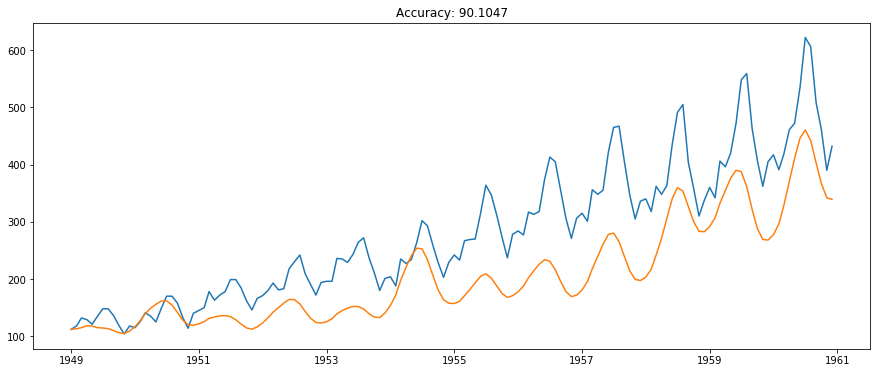

In [143]:
pred_ARIMA = np.exp(pred_ARIMA_log)
plt.plot(ts)
plt.plot(pred_ARIMA)
plt.title('Accuracy: %.4f'% np.sqrt(sum((pred_ARIMA-ts)**2)/len(ts)));

In [133]:
# From the graph above, we can find the result is pretty close to the actual line, so our model can work in some extent

# Reference:

In [135]:
# https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
# http://pandas.pydata.org/pandas-docs/stable/computation.html#exponentially-weighted-moment-functions
# https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/